In [ ]:
%reset -f

In [1]:
import pandas as pd
import lmfit
import matplotlib.pyplot as plt
import pystan
import emcee
from scipy.optimize import curve_fit
from lmfit import Model
import matplotlib
import numpy as np
import corner
plt.rcParams['figure.figsize'] = [12, 8]

The functions below will only help us reconstruct the images from pystan sampling/fitting results

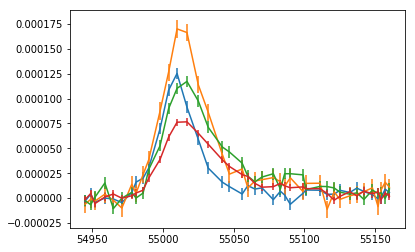

[0.9  2.01] [ 0.     14.0321]
mu2/mu1 = 2.233333333333333
delta_td = 14.0321


In [2]:
import LCSimulator as Alex

In [3]:
def kernel(a, b,l):
    sqd=np.subtract.outer(a,b)**2
    return np.exp(-0.5*sqd/(l*l))

def get_GP_mean(tp,P,t,l):
    K=kernel(tp,tp,l);       #NPxNP
    Ks=kernel(tp,t,l);       #NPxN
    L=np.linalg.cholesky(K)# + 1e-15*np.eye(NP)); #NPxNP
    Lk=np.linalg.solve(L,Ks);      #NPxN
    z=np.linalg.solve(L,P);        #NP
    m=np.dot(Lk.T,z)   # ((Lk)')*z;// N
    return m;

We now work on a particular system in the ztf-1a data. The system no is 37755722. Below we plot the light curve in each band (red, green and indigo).

In [4]:
df = pd.read_hdf('ztf-1a.h5', 'stacked')

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [5]:
A_Flux=Alex.flux()
A_time=Alex.time()
A_Fl_er=Alex.flerror()
mu=Alex.mu()
dt=Alex.td()

In [6]:
#sysn=37755722
#datapath="./"
#fin=datapath+'/ztf-1a.h5'
#dfI=pd.read_hdf(fin, 'image')
#print(dfI[dfI['sysno']==sysn]);
mus=mu; dts=dt
mu_expec=np.abs(mus[0]/mus[1]); dt_expec=dts[1]-dts[0]

print("Expected: mu=",mu_expec, "dt=",dt_expec)

Expected: mu= 0.4477611940298508 dt= 14.0321


In [ ]:
#DONT NEED NOW
sysn=37755722
#i=0
#test=pd.DataFrame(list(set(df['sysno'])),columns=['system_no'])[0]
#test[i][0]=sysn
tt=(df[(df['sysno'] == sysn)])

In [ ]:
#DONT NEED NOW
tr=tt[tt['filter']=='ztfr']['time']
tg=tt[tt['filter']=='ztfg']['time']
ti=tt[tt['filter']=='ztfi']['time']

fr=tt[tt['filter']=='ztfr']['flux']
fg=tt[tt['filter']=='ztfg']['flux']
fi=tt[tt['filter']=='ztfi']['flux']

sigfr=tt[tt['filter']=='ztfr']['fluxerr']
sigfg=tt[tt['filter']=='ztfg']['fluxerr']
sigfi=tt[tt['filter']=='ztfi']['fluxerr']

In [7]:
tr=A_time
tg=A_time
ti=A_time

fr=A_Flux[1]
fg=A_Flux[0]
fi=A_Flux[2]

sigfr=A_Fl_er[1]
sigfg=A_Fl_er[0]
sigfi=A_Fl_er[2]

<ErrorbarContainer object of 3 artists>

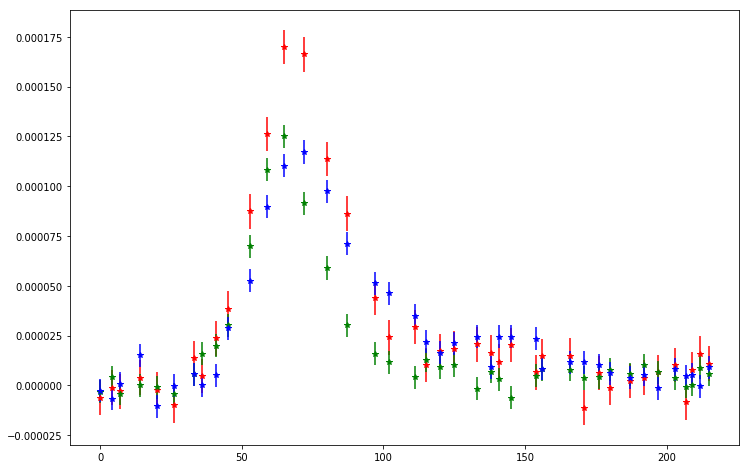

In [8]:
t_mins=np.array([np.amin(tr), np.amin(tg), np.amin(ti)])
t_maxs=np.array([np.amax(tr), np.amax(tg), np.amax(ti)])
t_min=np.amin(t_mins)-1e-5; t_max=np.amax(t_maxs)+1e-5;

# we substract a fixed time, it should not have any effect on the pystan results
tr=tr-t_min; tg=tg-t_min; ti=ti-t_min; 

t_max=t_max-t_min; t_min=0.0;

c=['r','g','b']
plt.rcParams['figure.figsize'] = [12, 8]
plt.errorbar(tr,fr,yerr=sigfr,fmt='%s*'%(c[0]))
plt.errorbar(tg,fg,yerr=sigfg,fmt='%s*'%(c[1]))
plt.errorbar(ti,fi,yerr=sigfi,fmt='%s*'%(c[2]))

In [ ]:
#sysn=37755722
#inp_path='../read_data/ztf-1a/'
#bands=['ztfr','ztfg','ztfi']
#fileN='ztf-1a_stackedflux_sysn%s_band_'%(sysn)

#fileNr=inp_path+fileN+bands[0];print(fileNr)
#fileNg=inp_path+fileN+bands[1];print(fileNg)
#fileNi=inp_path+fileN+bands[2];print(fileNi)

#tr,fr,sigfr=np.loadtxt(fileNr,usecols=[0,1,2], unpack=True)
#tg,fg,sigfg=np.loadtxt(fileNg,usecols=[0,1,2], unpack=True)
#ti,fi,sigfi=np.loadtxt(fileNi,usecols=[0,1,2], unpack=True)

#t_mins=np.array([np.amin(tr), np.amin(tg), np.amin(ti)])
#t_maxs=np.array([np.amax(tr), np.amax(tg), np.amax(ti)])
#t_min=np.amin(t_mins)-1e-5; t_max=np.amax(t_maxs)+1e-5;

# we substract a fixed time, it should not have any effect on the pystan results
#tr=tr-t_min; tg=tg-t_min; ti=ti-t_min; 

#t_max=t_max-t_min; t_min=0.0;

#c=['r','g','b']
#plt.rcParams['figure.figsize'] = [12, 8]
#plt.errorbar(tr,fr,yerr=sigfr,fmt='%s*'%(c[0]))
#plt.errorbar(tg,fg,yerr=sigfg,fmt='%s*'%(c[1]))
#plt.errorbar(ti,fi,yerr=sigfi,fmt='%s*'%(c[2]))

In [ ]:
print("printing the flux in r-band",fr)

Why first few data points on r-band have negative flux??

Details of images of the system: sysno==37755722

In [ ]:
from tables import *

We see that we have 2 images with a time delay of 6.036739 days. I am not sure what negative aplification means here (in the catalogue they said negative amplification means opposite "parity"!). Anyway, disregarding this negative sign we expect $\mu=1.625969/0.903586 \sim 1.8$ and $dt \sim 6.04$ from the following code.

First we try with $N_P=10$ for all the bands. The code below is not written nicely for now, rather it is written explicitly to avoid any mistake.

In [9]:

model = """
functions{
    matrix kernel1(vector x0, vector x1, real l, int d){
        matrix [d,d] a;
        for (i in 1:d)
        {
            for (j in 1:i)
            {
                a[i][j]=exp(-0.5*(x0[i]-x1[j])*(x0[i]-x1[j])/(l*l));
                a[j][i]=a[i][j];
            }
            
        }
        return a;
    }
    
    matrix kernel2(vector x0, vector x1, real l, int d1, int d2){
        matrix [d1,d2] a;
        for (i in 1:d1)
        {
            for (j in 1:d2)
            {
                a[i][j]=exp(-0.5*(x0[i]-x1[j])*(x0[i]-x1[j])/(l*l));
            }
            
        }
        return a;
    }
    //================== calculating GP mean function =============================
    vector GP_mean(vector tp, vector t, vector P, real l, int NP, int N)
    {
        matrix[NP,NP] K;
        matrix[NP,NP] L;
        matrix[NP,N] Ks;
        matrix[NP,N] Lk;
        vector[NP] z;
        vector[N] m;
    
        K=kernel1(tp,tp,l, NP);       //NPxNP
        #we add a small number to the diagonal elements of the cov matrix for stability in cholesky decomposition
        for (i in 1:NP){
            K[i,i]=K[i,i]+1e-12;
        }
        Ks=kernel2(tp,t,l, NP,N);       //NPxN
        L=cholesky_decompose(K); //NPxNP
        Lk=L\Ks;      //NPxN
        z=L\P;        //NP
        m=((Lk)')*z;// N
        return m;
    }
    //==============================================================================
}

data{

    int<lower=0> ni;
    int<lower=5> NP;

    int<lower=0> Nr;
    int<lower=0> Ng;
    int<lower=0> Ni;

    vector[Nr] tr;
    vector[Nr] yr;
    vector[Nr] yr_error;

    vector[Ng] tg;
    vector[Ng] yg;
    vector[Ng] yg_error;

    vector[Ni] ti;
    vector[Ni] yi;
    vector[Ni] yi_error;


    vector[NP] tp;
    real td;
    real dt_max;
}
parameters {
    vector <lower=0.0, upper=300> [NP] Pr;
    vector <lower=0.0, upper=300> [NP] Pg;
    vector <lower=0.0, upper=300> [NP] Pi;
    
    
    real<lower=5.0, upper=30.0> lr;
    real<lower=5.0, upper=30.0> lg;
    real<lower=5.0, upper=30.0> li;
    
    real<lower=0.25, upper=4.0> mu;//actually measuring amplitudes relative 
    real <lower=0, upper=dt_max> dt;
    
    
    
    
}


model {
    vector[Nr] dumr;
    vector[Ng] dumg;
    vector[Ni] dumi;

    //dum needs GP
    dumr=GP_mean(tp, tr, Pr, lr, NP, Nr); //first image
    dumr=dumr+mu*GP_mean(tp, tr+dt, Pr, lr, NP, Nr); //adding the 2nd image
    target+=normal_lpdf(yr|dumr,yr_error);
    
    dumg=GP_mean(tp, tg, Pg, lg, NP, Ng); //first image
    dumg=dumg+mu*GP_mean(tp, tg+dt, Pg, lg, NP, Ng); //adding the 2nd image
    target+=normal_lpdf(yg|dumg,yg_error);
    
    dumi=GP_mean(tp, ti, Pi, li, NP, Ni); //first image
    dumi=dumi+mu*GP_mean(tp, ti+dt, Pi, li, NP, Ni); //adding the 2nd image
    target+=normal_lpdf(yi|dumi,yi_error);

}
"""


In [ ]:
NI=2
NP=10;
dt_min=0.0; dt_max=15.0
#t_range=np.amax(t)-np.amin(t)
tp=np.linspace(t_min, t_max+dt_max, NP)
print("tp=",tp)
td=(t_max-t_min+dt_max-dt_min)/(NP-1); print("td=",td);
data = {'ni':NI,'NP':NP,
        'Nr': len(tr), 'Ng': len(tg), 'Ni': len(ti),'tr': tr, 'tg': tg, 'ti': ti,
        'yr': fr, 'yg': fg, 'yi': fi, 'yr_error':sigfr, 'yg_error':sigfg, 'yi_error':sigfi,
        'tp':tp,'td':td, 'dt_max':dt_max}

sm = pystan.StanModel(model_code=model)

fit2 = sm.sampling(data=data, iter=4000, chains=6, warmup=400, thin=3, seed=4201)#,control=dict(max_treedepth=15,adapt_delta=1.2))
print(fit2)

In [10]:
def contour(fit):
    print("Expected: mu=",mu_expec, "dt=",dt_expec)
    la = fit.extract(permuted=True)
    mu_pos = np.vstack((la['mu'])).T
    dt_pos = np.vstack((la['dt'])).T
    #print(mu_pos.shape)
    #P_pos=np.vstack((la['P'])).T
    postsamples = np.vstack((mu_pos, dt_pos)).T
    #print(postsamples.shape)
    fig = corner.corner(postsamples, labels=[r"$\mu$", r"$dt$"])
    #return fig

The code below reconstructs the individual images from the mean of the posterior samples of the parameters. We should get the best-fit, but for the time being we are just using mean. It should not be a problem as long as the chains converge

In [11]:
def rec(fit,pnr,png,pni):
    plt.rcParams['figure.figsize'] = [18,4 ]
    
    tpr=np.linspace(t_min, t_max+dt_max, pnr);
    tpg=np.linspace(t_min, t_max+dt_max, png);
    tpi=np.linspace(t_min, t_max+dt_max, pni);
    
    pp1=fit.get_posterior_mean()
    pos_mean=np.mean(pp1,axis=1)


    Pr_mean=pos_mean[np.arange(0,pnr)]; Pg_mean=pos_mean[np.arange(pnr,pnr+png)];
    Pi_mean=pos_mean[np.arange(pnr+png,pnr+png+pni)];
    print(len(pos_mean),len(Pr_mean),len(Pg_mean),len(Pi_mean))

    lrm=pos_mean[-6]; lgm=pos_mean[-5];lim=pos_mean[-4];

    mum=pos_mean[-3]; dtm=pos_mean[-2]; print("Mean of posterior: mu=",mum,"dt=",dtm,"\n")
    
    if(pnr==pni):
        print("P's are calculated at t= ",tpr)


    Ps1r=get_GP_mean(tpr,Pr_mean,tr,lrm)
    Ps2r=mum*get_GP_mean(tpr,Pr_mean,tr+dtm,lrm)
    rconst_signal_r=Ps1r+Ps2r#+Ps3+Ps4;
    Psr=Ps1r+Ps2r


    Ps1g=get_GP_mean(tpg,Pg_mean,tg,lgm)
    Ps2g=mum*get_GP_mean(tpg,Pg_mean,tg+dtm,lgm)
    rconst_signal_g=Ps1g+Ps2g#+Ps3+Ps4;
    Psg=Ps1g+Ps2g

    Ps1i=get_GP_mean(tpi,Pi_mean,ti,lim)
    Ps2i=mum*get_GP_mean(tpi,Pi_mean,ti+dtm,lim)
    rconst_signal_i=Ps1i+Ps2i#+Ps3+Ps4;
    Psi=Ps1i+Ps2i

    chisq_r=np.sum((Psr-fr)**2/sigfr**2); 
    chisq_g=np.sum((Psg-fg)**2/sigfg**2); 
    chisq_i=np.sum((Psi-fi)**2/sigfi**2);
    
    print("\n Reduced Chi^2-->r-band ",np.sum((Psr[7:35]-fr[7:35])**2/sigfr[7:35]**2) )
    #print("\n Psr, fr, sigfr",np.shape(Psr),np.shape(fr),np.shape(sigfr))
    print("\n \nchi^2--> r-band=",chisq_r, ", g-band=",chisq_g, ", i-band=", chisq_i)
    print("data points in r-band=",len(tr), ", g-band=",len(tg), ", i-band=",len(ti))
    plt.subplot(1, 3, 1)
    plt.errorbar(tr,fr,yerr=sigfr,fmt='%s*'%(c[0]), label=r"r-band data")
    plt.plot(tr,Psr, c=c[0], label=r"combined reconstruction" )
    plt.plot(tr,Ps1r, ls="dotted", c=c[0], label=r"pystan image 1")
    plt.plot(tr,Ps2r, ls="dashdot", c=c[0], label=r"pystan image 2")
    plt.scatter(tpr, Pr_mean, c="k", s=15, label=r"parameters P")
    plt.legend()
    

    plt.subplot(1, 3, 2)
    plt.errorbar(tg,fg,yerr=sigfg,fmt='%s*'%(c[1]), label=r"g-band data")
    plt.plot(tg,Psg, c=c[1], label=r"combined reconstruction")
    plt.plot(tg,Ps1g, ls="dotted", c=c[1], label=r"pystan image 1")
    plt.plot(tg,Ps2g, ls="dashdot", c=c[1], label=r"pystan image 2")
    plt.scatter(tpg, Pg_mean, c="k", s=15, label=r"parameters P")
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.errorbar(ti,fi,yerr=sigfi,fmt='%s*'%(c[2]), label=r"i-band data")
    plt.plot(ti,Psi, c=c[2], label=r"combined reconstruction")
    plt.plot(ti,Ps1i, ls="dotted", c=c[2], label=r"pystan image 1")
    plt.plot(ti,Ps2i, ls="dashdot", c=c[2], label=r"pystan image 2")
    plt.scatter(tpi, Pi_mean, c="k", s=15, label=r"parameters P")
    plt.legend()
    plt.show()

In [ ]:
contour(fit2)

In [ ]:
rec(fit2,10,10,10)

The overall $\chi^2$ is good. The constrained $\mu \approx 1.7 \pm 0.11$ is also nice. But the time delay ($dt \approx 10.8 \pm 0.2$) is much higher than expected. This is possibly because my parameters P are very much spread in time. Possibly we need higher NP. Look at the i-band. The reconstructed signal looks bad. Possibly we need fewer parameters for i-band.

Below we try with NP=15, same for all the bands.

In [19]:
# Function for changing the tp spacing
def tp_new(NP,dt_min,dt_max):
    intv = ((t_max+dt_max)-t_min)/NP-1
    x0 = t_min
    x_end = (t_max+dt_max)
    x_0_eps = np.linspace(x0,x0+4*intv,2)# first 4 points reduced with 2 pts
    x_end_eps = np.linspace(x_end-4*intv,x_end,2) # same, Last 4 points
    x_mid = np.linspace(x0+5*intv,x_end-5*intv,11)
    xt = np.concatenate((x_0_eps,x_mid,x_end_eps))
    return xt     

In [21]:
# Testing
tp_new(NP,dt_min,dt_max)

array([  0.        ,  57.33333867,  71.66667333,  80.33334067,
        89.000008  ,  97.66667533, 106.33334267, 115.00001   ,
       123.66667733, 132.33334467, 141.000012  , 149.66667933,
       158.33334667, 172.66668133, 230.00002   ])

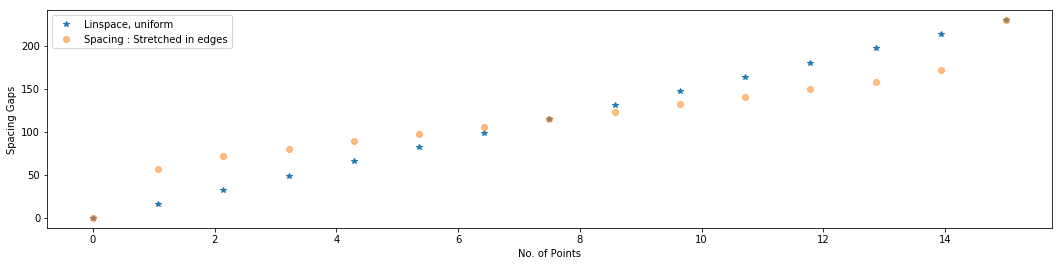

In [29]:
plt.plot(np.linspace(0, NP, NP),np.linspace(t_min, t_max+dt_max, NP),'*',label='Linspace, uniform')
plt.plot(np.linspace(0, NP, NP),tp_new(NP,dt_min,dt_max),'o',alpha=0.5,label='Spacing : Stretched in edges')
plt.xlabel('No. of Points')
plt.ylabel('Spacing Gaps')
plt.legend()

In [16]:
NI=2
NP=15;
dt_min=0.0; dt_max=15.0
#t_range=np.amax(t)-np.amin(t)
#tp=np.linspace(t_min, t_max+dt_max, NP)
tp = tp_new(NP,dt_min,dt_max) #xt   #New tp
print("tp=",tp)
td=(t_max-t_min+dt_max-dt_min)/(NP-1); print("td=",td);
data = {'ni':NI,'NP':NP,
        'Nr': len(tr), 'Ng': len(tg), 'Ni': len(ti),'tr': tr, 'tg': tg, 'ti': ti,
        'yr': fr, 'yg': fg, 'yi': fi, 'yr_error':sigfr, 'yg_error':sigfg, 'yi_error':sigfi,
        'tp':tp,'td':td, 'dt_max':dt_max}

sm = pystan.StanModel(model_code=model)

fit3 = sm.sampling(data=data, iter=4000, chains=6, warmup=400, thin=3, seed=4201)#,control=dict(max_treedepth=15,adapt_delta=1.2))
print(fit3)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8c311571e3884dc0539471611f2ee76f NOW.


tp= [  0.          57.33333867  71.66667333  80.33334067  89.000008
  97.66667533 106.33334267 115.00001    123.66667733 132.33334467
 141.000012   149.66667933 158.33334667 172.66668133 230.00002   ]
td= 16.42857285714334


Inference for Stan model: anon_model_8c311571e3884dc0539471611f2ee76f.
6 chains, each with iter=4000; warmup=400; thin=3; 
post-warmup draws per chain=1200, total post-warmup draws=7200.

          mean se_mean     sd    2.5%     25%     50%    75%  97.5%  n_eff   Rhat
Pr[1]    37.48   48.38  83.81  1.4e-7  1.4e-6  3.2e-6 6.8e-6 224.88      3  3.7e7
Pr[2]    22.42   28.93  50.12  5.3e-5  7.0e-5  7.7e-5 8.5e-5 134.49      3  5.8e6
Pr[3]    21.43   27.67  47.93  1.2e-4  1.4e-4  1.4e-4 1.5e-4  128.6      3  5.7e6
Pr[4]     6.13    7.91  13.71  7.0e-5  8.5e-5  9.4e-5 1.0e-4  36.78      3  1.5e6
Pr[5]    10.64   13.73  23.79  5.4e-5  6.8e-5  7.6e-5 8.6e-5  63.83      3  2.6e6
Pr[6]    15.42   19.91  34.49  1.2e-5  2.5e-5  3.2e-5 4.1e-5  92.53      3  4.4e6
Pr[7]     8.43   10.88  18.85  5.7e-6  2.0e-5  2.9e-5 4.0e-5  50.58      3  2.0e6
Pr[8]     43.3   55.89  96.82  1.1e-6  7.3e-6  1.3e-5 2.0e-5 259.77      3  1.7e7
Pr[9]     6.89    8.89   15.4  2.2e-6  9.9e-6  1.5e-5 2.3e-5  41.33      3

Expected: mu= 0.4477611940298508 dt= 14.0321


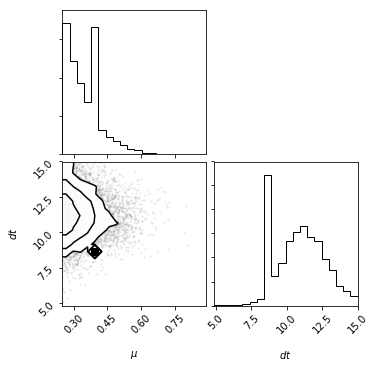

In [17]:
contour(fit3)

51 15 15 15
Mean of posterior: mu= 0.3464725581377513 dt= 10.83497236609896 

P's are calculated at t=  [  0.          16.42857286  32.85714571  49.28571857  65.71429143
  82.14286429  98.57143714 115.00001    131.42858286 147.85715571
 164.28572857 180.71430143 197.14287429 213.57144714 230.00002   ]

 Reduced Chi^2-->r-band  283675221129546.3

 
chi^2--> r-band= 416222527674304.94 , g-band= 903689255327216.0 , i-band= 619375871145613.8
data points in r-band= 40 , g-band= 40 , i-band= 40


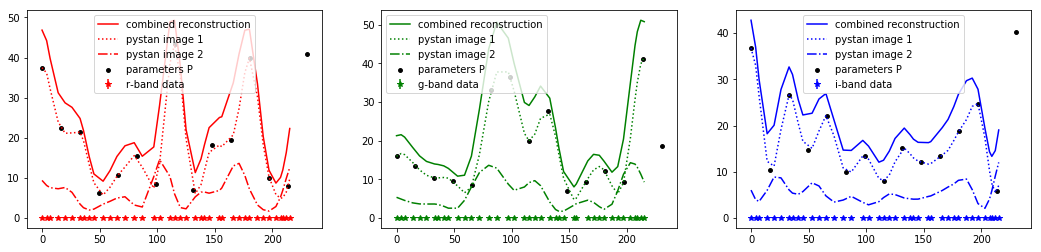

In [18]:
npn=15
rec(fit3, npn,npn,npn)

Again the overall fit is quite good. The time delay, $dt = 7.78 \pm 2.16$ is better now. But now the amplification ($\mu$) is too small (for a very small $\mu$, the time delay does not matter much). This is possibly because of more freedom to the first image. The i-band images are bad. Note that the fitting prefers smaller value of lg (smoothing in the kernel for the g-band) to fit the wiggles at the high t in g-band.

Below we try with NP=8, same for all the bands.

In [ ]:
NP=8;
dt_min=0.0; dt_max=15.0
#t_range=np.amax(t)-np.amin(t)
#tp=np.linspace(t_min, t_max+dt_max, NP)
tp=tp_new(NP,dt_min,dt_max)
print("tp=",tp)
td=(t_max-t_min+dt_max-dt_min)/(NP-1); print("td=",td);
data = {'ni':NI,'NP':NP,
        'Nr': len(tr), 'Ng': len(tg), 'Ni': len(ti),'tr': tr, 'tg': tg, 'ti': ti,
        'yr': fr, 'yg': fg, 'yi': fi, 'yr_error':sigfr, 'yg_error':sigfg, 'yi_error':sigfi,
        'tp':tp,'td':td, 'dt_max':dt_max}

sm = pystan.StanModel(model_code=model)

fit0 = sm.sampling(data=data, iter=4000, chains=6, warmup=400, thin=3, seed=4201)#,control=dict(max_treedepth=15,adapt_delta=1.2))
print(fit0)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8c311571e3884dc0539471611f2ee76f NOW.


tp= [  0.        111.00001   138.7500125 134.000012  129.2500115 124.500011
 119.7500105 115.00001   110.2500095 105.500009  100.7500085  96.000008
  91.2500075 119.00001   230.00002  ]
td= 32.85714571428668


In [ ]:
contour(fit0)

In [ ]:
rec(fit0, 8,8,8)

The above fit is very bad, but at least the i-band images look a bit nicer!

Let us try with different number of parameters for different bands. NP=15 for red and green bands, while NP=8 for i-band.

In [ ]:

model = """
functions{
    matrix kernel1(vector x0, vector x1, real l, int d){
        matrix [d,d] a;
        for (i in 1:d)
        {
            for (j in 1:i)
            {
                a[i][j]=exp(-0.5*(x0[i]-x1[j])*(x0[i]-x1[j])/(l*l));
                a[j][i]=a[i][j];
            }
            
        }
        return a;
    }
    
    matrix kernel2(vector x0, vector x1, real l, int d1, int d2){
        matrix [d1,d2] a;
        for (i in 1:d1)
        {
            for (j in 1:d2)
            {
                a[i][j]=exp(-0.5*(x0[i]-x1[j])*(x0[i]-x1[j])/(l*l));
            }
            
        }
        return a;
    }
    //================== calculating GP mean function =============================
    vector GP_mean(vector tp, vector t, vector P, real l, int NP, int N)
    {
        matrix[NP,NP] K;
        matrix[NP,NP] L;
        matrix[NP,N] Ks;
        matrix[NP,N] Lk;
        vector[NP] z;
        vector[N] m;
    
        K=kernel1(tp,tp,l, NP);       //NPxNP
        Ks=kernel2(tp,t,l, NP,N);       //NPxN
        L=cholesky_decompose(K); //NPxNP
        Lk=L\Ks;      //NPxN
        z=L\P;        //NP
        m=((Lk)')*z;// N
        return m;
    }
    //==============================================================================
}

data{

    int<lower=0> ni;
    
    int<lower=5> NPr;
    int<lower=5> NPg;
    int<lower=5> NPi;

    int<lower=0> Nr;
    int<lower=0> Ng;
    int<lower=0> Ni;

    vector[Nr] tr;
    vector[Nr] yr;
    vector[Nr] yr_error;

    vector[Ng] tg;
    vector[Ng] yg;
    vector[Ng] yg_error;

    vector[Ni] ti;
    vector[Ni] yi;
    vector[Ni] yi_error;


    vector[NPr] tpr;
    vector[NPg] tpg;
    vector[NPi] tpi;
    
    real dt_max;
}
parameters {
    vector <lower=0.0, upper=300.0> [NPr] Pr;
    vector <lower=0.0, upper=300.0> [NPg] Pg;
    vector <lower=0.0, upper=300.0> [NPi] Pi;
    
    
    real<lower=5.0, upper=30.0> lr;
    real<lower=5.0, upper=30.0> lg;
    real<lower=5.0, upper=30.0> li;
    
    real<lower=0.25, upper=4.0> mu;//actually measuring amplitudes relative 
    real <lower=0, upper=dt_max> dt;
    
    
    
    
}


model {
    vector[Nr] dumr;
    vector[Ng] dumg;
    vector[Ni] dumi;

    //dum needs GP
    dumr=GP_mean(tpr, tr, Pr, lr, NPr, Nr); //first image
    dumr=dumr+mu*GP_mean(tpr, tr+dt, Pr, lr, NPr, Nr); //adding the 2nd image
    target+=normal_lpdf(yr|dumr,yr_error);
    
    dumg=GP_mean(tpg, tg, Pg, lg, NPg, Ng); //first image
    dumg=dumg+mu*GP_mean(tpg, tg+dt, Pg, lg, NPg, Ng); //adding the 2nd image
    target+=normal_lpdf(yg|dumg,yg_error);
    
    dumi=GP_mean(tpi, ti, Pi, li, NPi, Ni); //first image
    dumi=dumi+mu*GP_mean(tpi, ti+dt, Pi, li, NPi, Ni); //adding the 2nd image
    target+=normal_lpdf(yi|dumi,yi_error);

}
"""
NI=2
NPr=14; NPg=14; NPi=8;# number of parameters is different for different bands
dt_min=0.0; dt_max=15.0
#now we calculate the time array for each band since the number of parameters can be different
tpr=np.linspace(t_min, t_max+dt_max, NPr); tpg=np.linspace(t_min, t_max+dt_max, NPg); 
tpi=np.linspace(t_min, t_max+dt_max, NPi); 
data = {'ni':NI,'NPr':NPr,'NPg':NPg,'NPi':NPi,
        'Nr': len(tr), 'Ng': len(tg), 'Ni': len(ti),'tr': tr, 'tg': tg, 'ti': ti,
        'yr': fr, 'yg': fg, 'yi': fi, 'yr_error':sigfr, 'yg_error':sigfg, 'yi_error':sigfi,
        'tpr':tpr,'tpg':tpg,'tpi':tpi, 'dt_max':dt_max}

sm = pystan.StanModel(model_code=model)

fit4 = sm.sampling(data=data, iter=5000, chains=4, warmup=400, thin=3, seed=301)#,control=dict(max_treedepth=15,adapt_delta=1.2))
print(fit4)

In [ ]:
contour(fit4)

In [ ]:
rec(fit4, NPr,NPg,NPi)

Results are bad. Both $\mu$ and $dt$ are very small. I am working on it. Note that the fitting prefers smaller value of lg (in the kernel) for the g-band to fit the wiggles at the higher t. 

Below, let us try with NP=15 for r and g bands, and NP=8 for the i-band.

In [ ]:
NPr=15; NPg=15; NPi=8;# number of parameters is different for different bands
dt_min=0.0; dt_max=15.0
#now we calculate the time array for each band since the number of parameters can be different
tpr=np.linspace(t_min, t_max+dt_max, NPr); tpg=np.linspace(t_min, t_max+dt_max, NPg); 
tpi=np.linspace(t_min, t_max+dt_max, NPi); 
data = {'ni':NI,'NPr':NPr,'NPg':NPg,'NPi':NPi,
        'Nr': len(tr), 'Ng': len(tg), 'Ni': len(ti),'tr': tr, 'tg': tg, 'ti': ti,
        'yr': fr, 'yg': fg, 'yi': fi, 'yr_error':sigfr, 'yg_error':sigfg, 'yi_error':sigfi,
        'tpr':tpr,'tpg':tpg,'tpi':tpi, 'dt_max':dt_max}

sm = pystan.StanModel(model_code=model)

fit7 = sm.sampling(data=data, iter=5000, chains=4, warmup=400, thin=3, seed=301)#,control=dict(max_treedepth=15,adapt_delta=1.2))
print(fit7)

In [ ]:
contour(fit7)

In [ ]:
rec(fit7, NPr,NPg,NPi)

Similarly bad results.